In [80]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
from scipy.optimize import fsolve 
import sys
import time
from scipy import optimize
from numpy import savetxt

In [81]:
Dimensions=400
Dimensions_1 = 200
Dimensions_2= 200
PI = np.pi
K = 0.5631
DEGREE = 2
global Dimensions, PI, K,DEGREE

In [82]:
a1=np.linspace(1e-12,0.5-(0.999-0.5)/Dimensions_2, Dimensions_1) 
a2=np.linspace(0.5,0.999, Dimensions_2) 
C_RANGES= np.reshape(np.concatenate((a1, a2), axis=0), (-1,1))
THETA_RANGES = np.linspace(0, 2*PI, Dimensions)

In [83]:
def pertubation(theta, N):
    return np.cos(N*theta)

In [84]:
def dev_pertubation(theta, N):
    return -N*np.sin(N*theta)

In [85]:
def radius(theta, c, m, N):
    pertu = pertubation(theta, N)
    scalling = 1/(np.power((1+c), m))##########Test
    #r = (scalling*(1-c)+(np.power(1-c, m**DEGREE)*0.05*pertu))*K###use 0.561 to sure the surface = 1
    r=scalling*(1-c)**0.5*K+(np.power(1-c, 4)*0.05*pertu)
    return r

In [86]:
def Dev_r_theta(theta, c, m, N):
    dev_per = dev_pertubation(theta, N)
    #d_r = 0.05*np.power((1-c), m**DEGREE)*dev_per
    d_r = 0.05*np.power((1-c), 4)*dev_per
    return d_r

In [87]:
def Dev_r_c(theta, c, m, N):
    pertu = pertubation(theta, N)*0.05
    A = 1/(np.power((1+c), m))
    #B = (1-c)*K
    B = (1-c)**0.5*K
    dA = -m*np.power(1+c, -m-1)
    #dB = -K
    dB = -0.5*K*(1-c)**(0.5-1)
    #dC = -K*pertu*(m**DEGREE)*((1-c)**((m**DEGREE)-1))####require C != 1, when C == 1, there will be a signarity.
    dC = pertu*(4)*((1-c)**((4)-1))
    d_r = A*dB+B*dA+dC
    return d_r

In [88]:
def Dev_h_c(c, n):
    d_h = n*np.power(c, n-1)####set c_max=1
    return d_h

In [89]:
def Height_volume(v, n, M, Radius, Theta_ranges, C_ranges, N_circular):
    dimen_c = len(C_ranges)
    
    d_theta = Theta_ranges[1]-Theta_ranges[0]#(Theta_ranges[-1]-Theta_ranges[0])/Dimensions
    C_RANGES_diff = np.diff(C_ranges, axis=0)
    C_RANGES_diff = np.reshape(np.append(C_RANGES_diff, C_RANGES_diff[-1,0] ), (-1,1))
    d_c = C_RANGES_diff
    d_base_area = 0.5*(Radius**2)*d_theta


    d_h = Dev_h_c(C_ranges, n)
    dv = (d_base_area*d_h)*d_c

    volume = np.sum(dv)

    H = v/volume
     
    d_r_theta = Dev_r_theta(Theta_ranges, C_ranges, M, N_circular)
    d_r_c = Dev_r_c(Theta_ranges, C_ranges, M, N_circular)
  
    d_h_c = H*d_h
    
    
    ds = np.sqrt(Radius**2+d_r_theta**2)*d_theta
    dl = np.sqrt(d_r_c**2+d_h_c**2)*d_c
    
    surface = ds*dl

    
    surface_size = np.sum(surface)
    
    return H, surface_size

In [90]:
def Main(v, n_ranges, m_ranges, Theta_ranges, C_ranges, N_circular):
    n_length = len(n_ranges)
    m_length = len(m_ranges)
    surface_matrix = np.zeros((m_length, n_length))
    height_matrix = np.zeros((m_length, n_length))
    for i in range(m_length):
        Radius = radius(Theta_ranges, C_ranges, m_ranges[i], N_circular)
        for j in range(n_length):
            height, surface = Height_volume(v, n_ranges[j], m_ranges[i], Radius, Theta_ranges, C_ranges, N_circular)
            surface_matrix[i][j] = surface
            height_matrix[i][j] = height
    surface_min = surface_matrix.min()
    index = np.where(surface_matrix==np.min(surface_matrix))
    height_min = height_matrix[index][0]
    return surface_min, height_min, surface_matrix

In [91]:
def loop_volume(v, N_circular):
    m_l=[1, 0.5,0.1,0.05,0.01,0.005,0.001]
    n_l=[0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
    levels = len(m_l)
    n_start = 0.5
    n_stop = 3
    m_start = -10
    m_stop = 20
    i = 0 
    Start = True
    while (i<levels):
        dimen = 200
        if (Start==True):
            m_ranges = np.arange(m_start, m_stop, m_l[i])
            n_ranges = np.arange(n_start,n_stop, n_l[i])
            Start = False
        else:
            pass
#         print(m_ranges)
#         print(n_ranges)
        s_g, h_g,energy_g= Main(v,n_ranges, m_ranges, THETA_RANGES, C_RANGES, N_circular)
        index = np.where(energy_g == np.min(energy_g))
        m = index[0][0]
        n = index[1][0]
#         print('i', i)
#         print('m', m)
#         print('n', n)
        m_lst_index = len(m_ranges)-1
        n_lst_index = len(n_ranges)-1
        if (m ==0)|(m==m_lst_index)|(n==0)|(n==n_lst_index):
            m_ranges = np.arange(m_ranges[m]-m_l[i], m_ranges[m]+2*m_l[i], m_l[i])
            n_ranges = np.arange(n_ranges[n]-n_l[i], n_ranges[n]+2*n_l[i], n_l[i])
        else:
            if (i+1) <levels:
                m_ranges = np.arange(m_ranges[m]-m_l[i], m_ranges[m]+m_l[i]+m_l[i+1], m_l[i+1])
                n_ranges = np.arange(n_ranges[n]-n_l[i], n_ranges[n]+n_l[i]+n_l[i+1], n_l[i+1])
                i = i+1
            else:
                break
    surface = s_g
    height = h_g
    Energy = energy_g
    return surface, height, Energy,  m_ranges[m], n_ranges[n]

### N_c =2,3,4,5,6,7,8

In [92]:
N_c = 2
Volume = 0.1
Surface_2, Height_2, Energy_2, m_2, n_2 = loop_volume(Volume, N_c)

In [93]:
Volume = 0.1
#N_cs = [3,4,5,6,8,20]
N_cs = [4, 8, 12, 16, 20]
Surface = []
Height = []
Energy = []
m_matrix = []
n_matrix = []
for N_c in N_cs:
    s,h,e,m,n = loop_volume(Volume, N_c)
    Surface.append(s)
    Height.append(h)
    Energy.append(e)
    m_matrix.append(m)
    n_matrix.append(n)

In [94]:
Height

[0.19833616763297607,
 0.19941961014367077,
 0.20150116863327622,
 0.20332720002957222,
 0.2050314212271017]

In [95]:
Surface

[1.1226479932132458,
 1.133484091256835,
 1.1460891626417482,
 1.1597442108893825,
 1.1737807161581544]

In [96]:
m_matrix

[-0.015000000000000104,
 -0.20500000000000002,
 -0.282,
 -0.33699999999999997,
 -0.38000000000000006]

In [97]:
n_matrix

[1.0033,
 1.2711999999999954,
 1.4445000000000032,
 1.5941000000000003,
 1.7300000000000035]

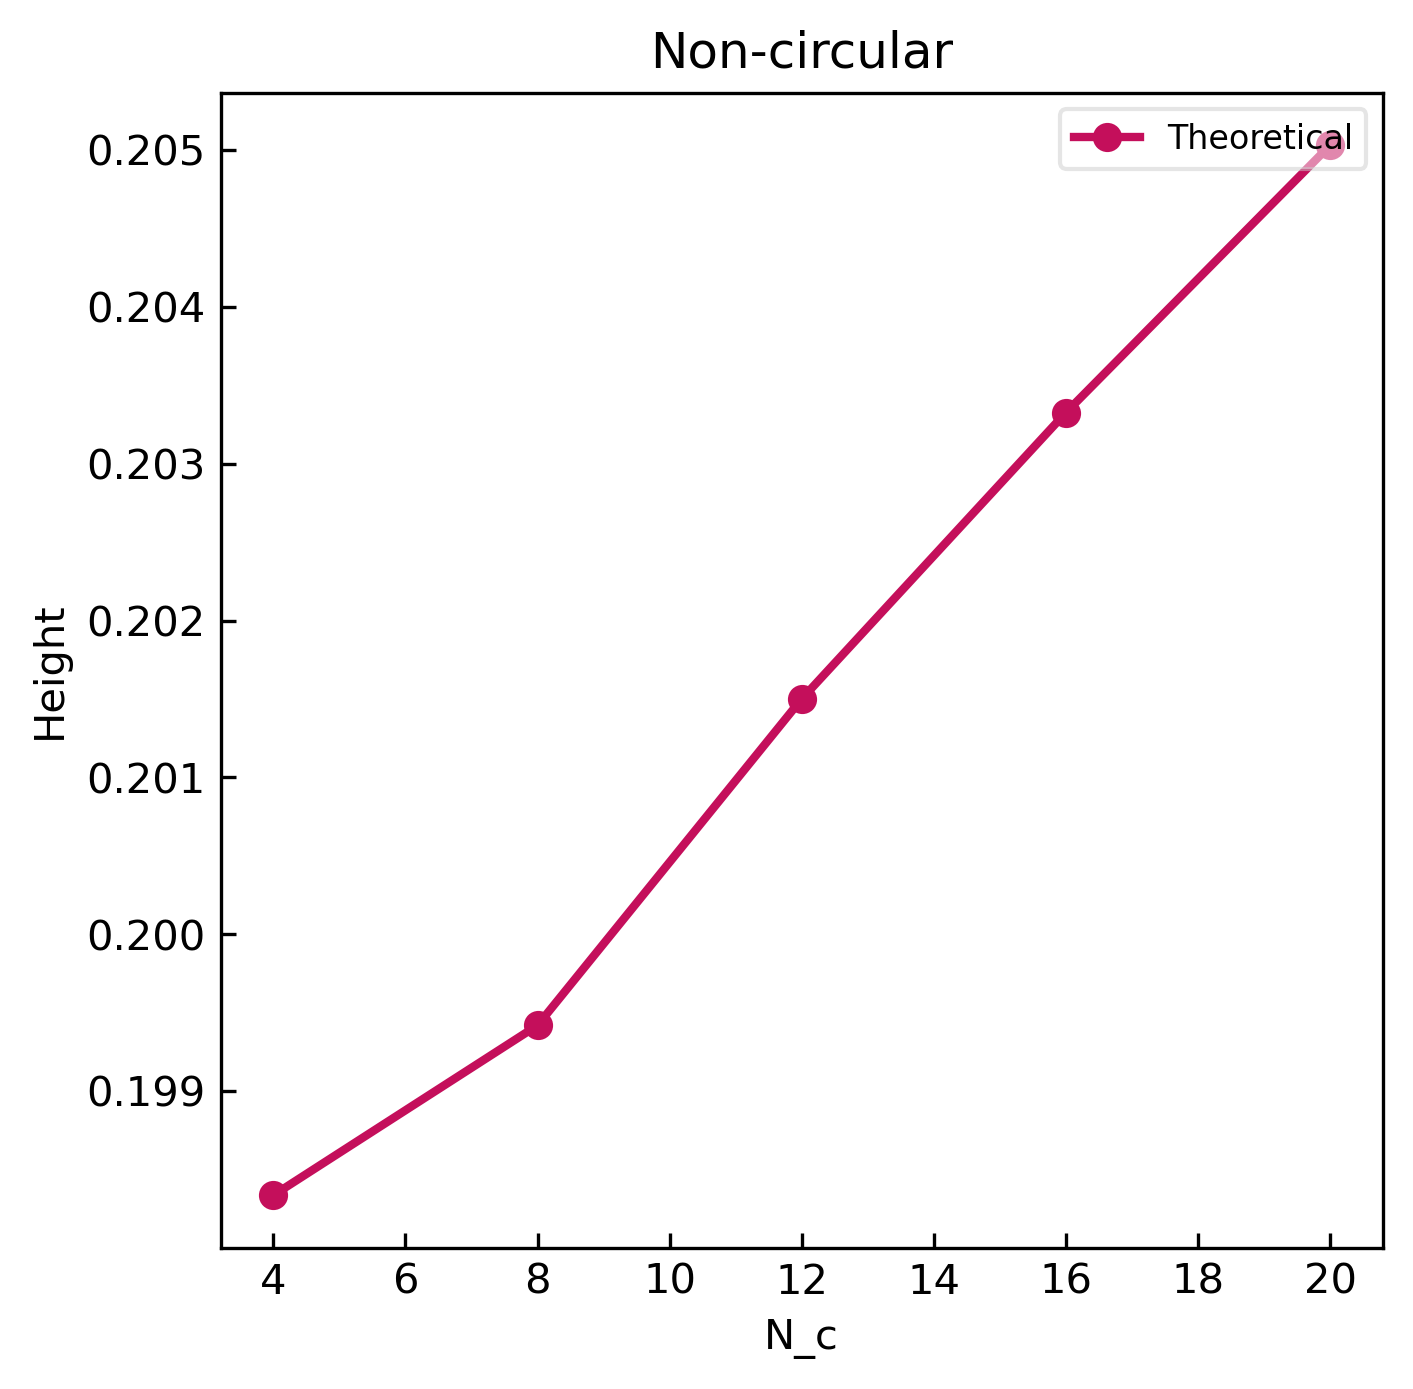

In [98]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax_1=fig.add_subplot(1,1,1)




ax_1.plot(N_cs,Height,color="#C40f5B",lw =2, marker = 'o', label = 'Theoretical')

ax_1.set_title('Non-circular')
ax_1.set_ylabel('Height')
ax_1.set_xlabel('N_c')


ax_1.legend(loc='upper right', fontsize=8, numpoints=1, framealpha=0.5)
ax_1.tick_params(axis="y", direction='in')
ax_1.tick_params(axis="x", direction='in')
plt.savefig('non_circular_Height.pdf', bbox_inches='tight')

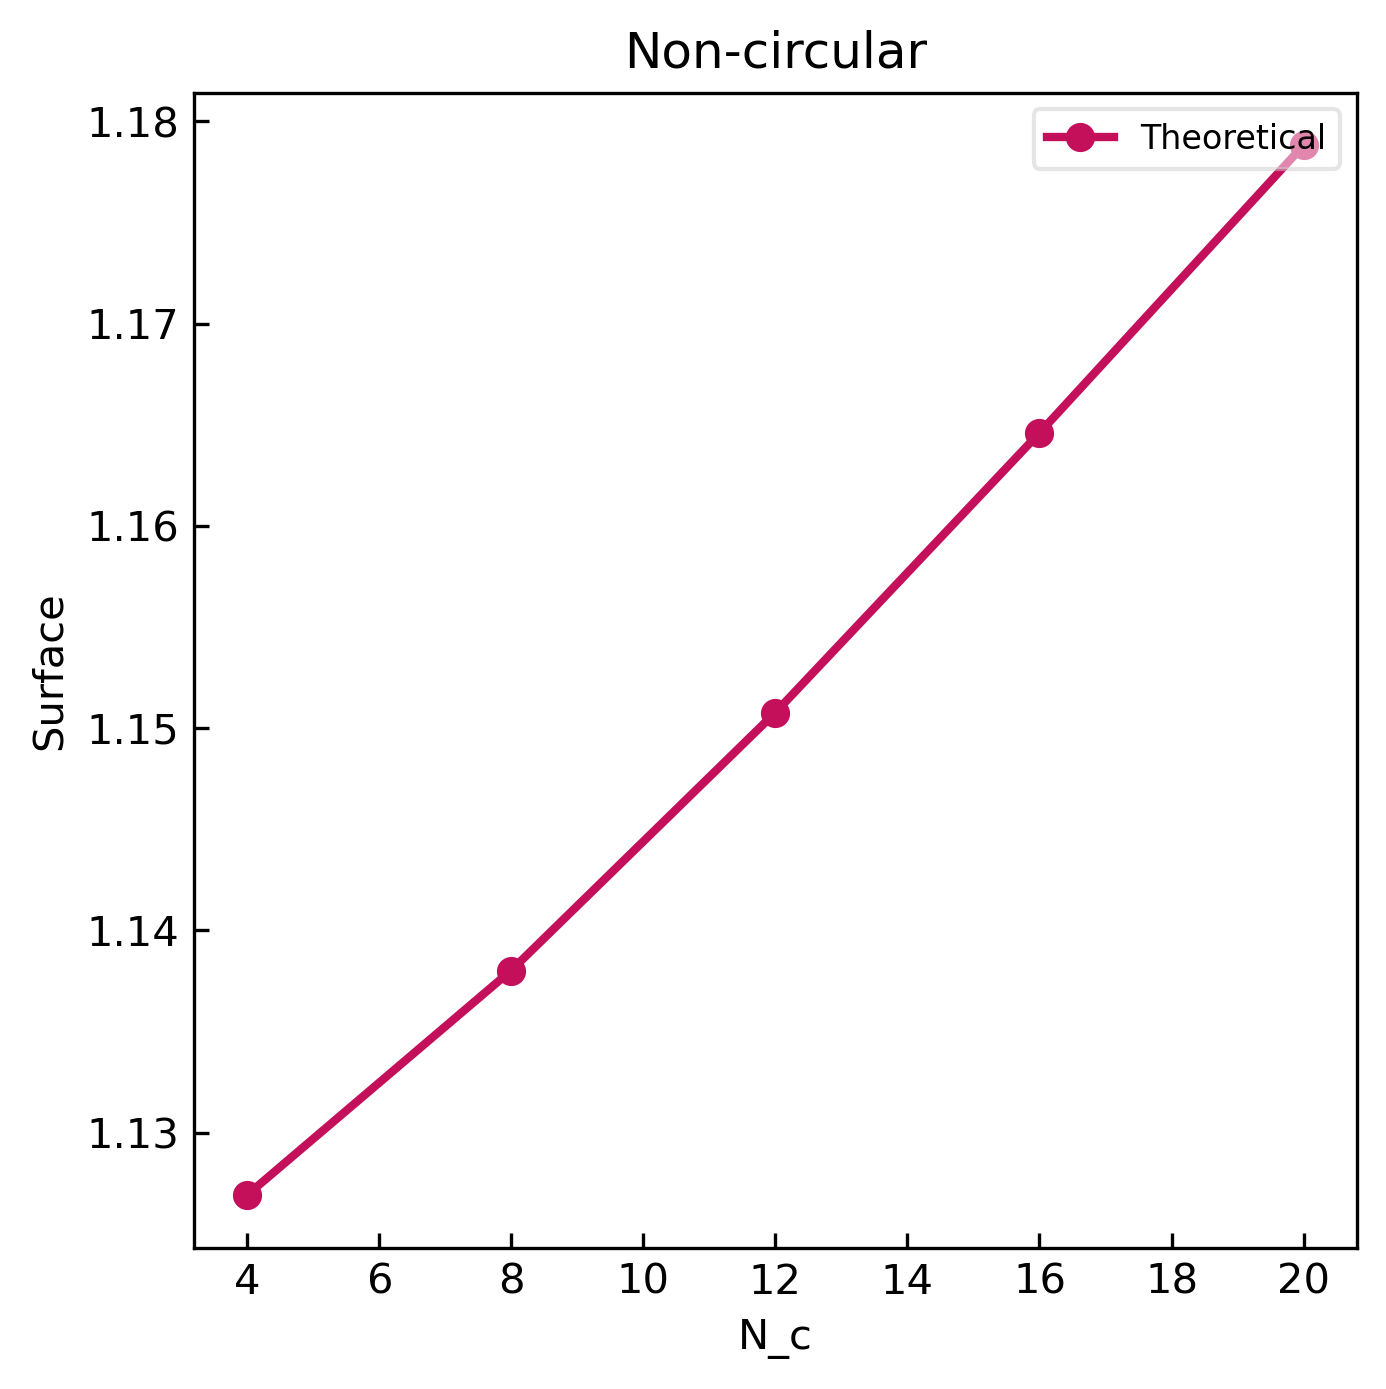

In [20]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax_1=fig.add_subplot(1,1,1)




ax_1.plot(N_cs,Surface,color="#C40f5B",lw =2, marker = 'o', label = 'Theoretical')

ax_1.set_title('Non-circular')
ax_1.set_ylabel('Surface')
ax_1.set_xlabel('N_c')


ax_1.legend(loc='upper right', fontsize=8, numpoints=1, framealpha=0.5)
ax_1.tick_params(axis="y", direction='in')
ax_1.tick_params(axis="x", direction='in')
plt.savefig('non_circular_surface.pdf', bbox_inches='tight')

N=2

In [67]:
Radius = radius(THETA_RANGES, C_RANGES, m_matrix[0], N_cs[0])
Radius.shape
x = Radius*np.cos(THETA_RANGES)
y = Radius*np.sin(THETA_RANGES)
z = Height[0]*(C_RANGES)**n_matrix[0]
z_0 = np.ones(THETA_RANGES.shape[0])

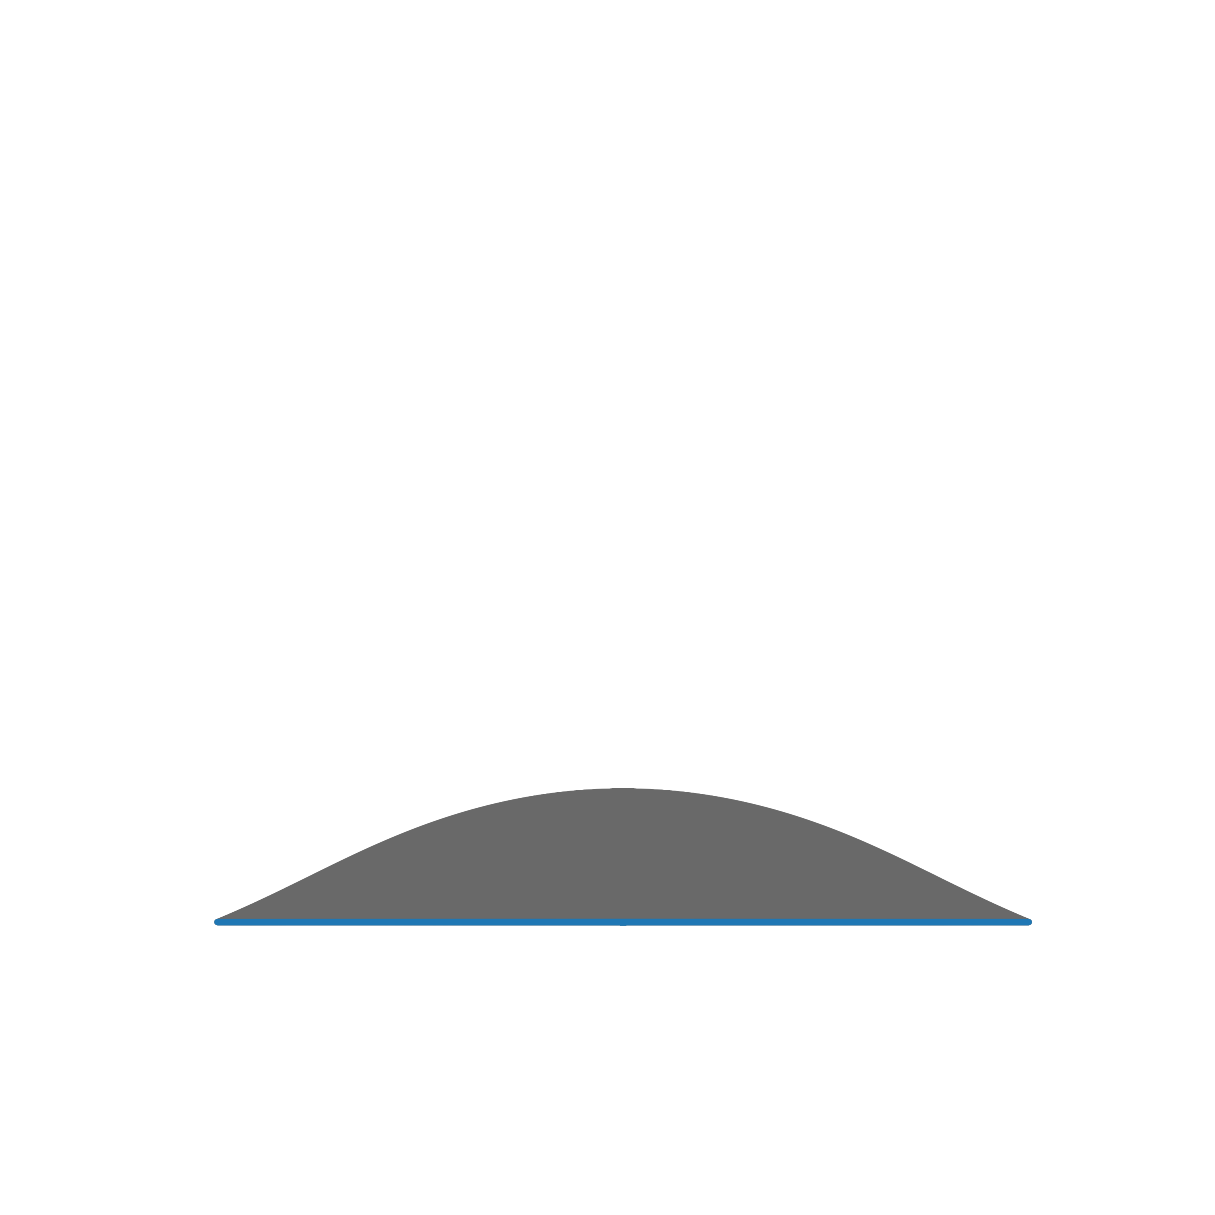

In [68]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
ax.view_init(elev=-3, azim=0)
#ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=0)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,1):
        ax.plot(x[i], y[i], z_0*z[i], color='dimgrey')
#ax.plot(x[190],y[190],z_0*z[190])
ax.plot(x[0],y[0],z_0*z[0])
ax.set_zlim(0, 1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)


ax.set_axis_off()
ax.grid(False)
fig.savefig('1_side.pdf', bbox_inches='tight')

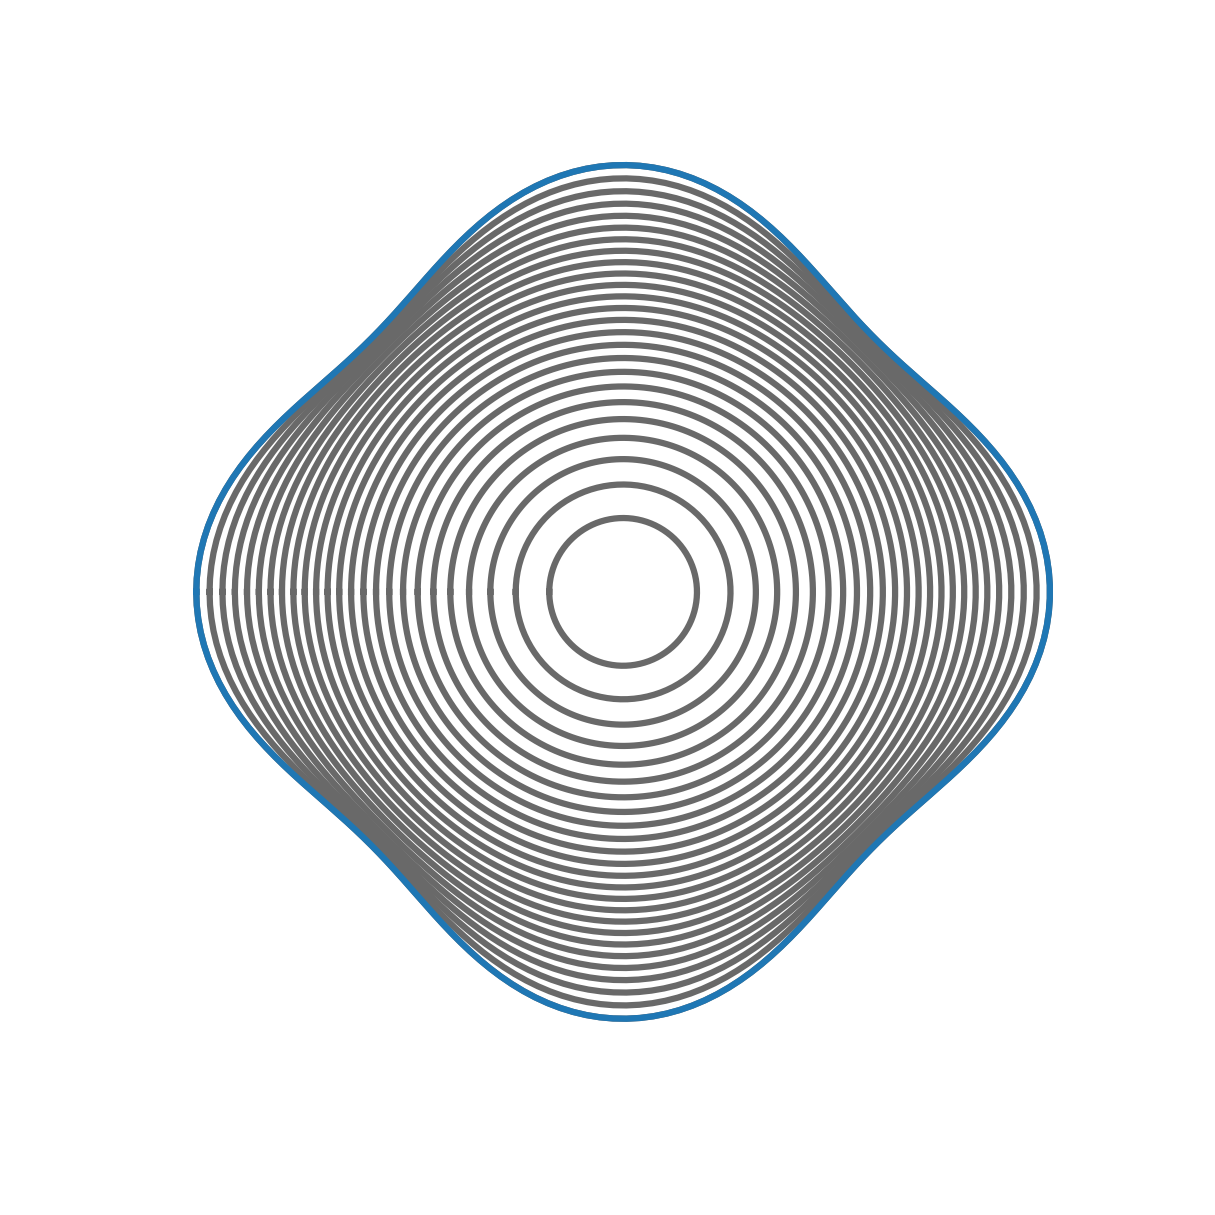

In [69]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
#ax.view_init(elev=-3, azim=0)
ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=0)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,8):
        ax.plot(x[i], y[i], z_0*z[i], color='dimgrey')
#ax.plot(x[190],y[190],z_0*z[190])
ax.plot(x[0],y[0],z_0*z[0])
ax.set_zlim(0, 1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)



ax.set_axis_off()
ax.grid(False)
fig.savefig('1_top.pdf', bbox_inches='tight')

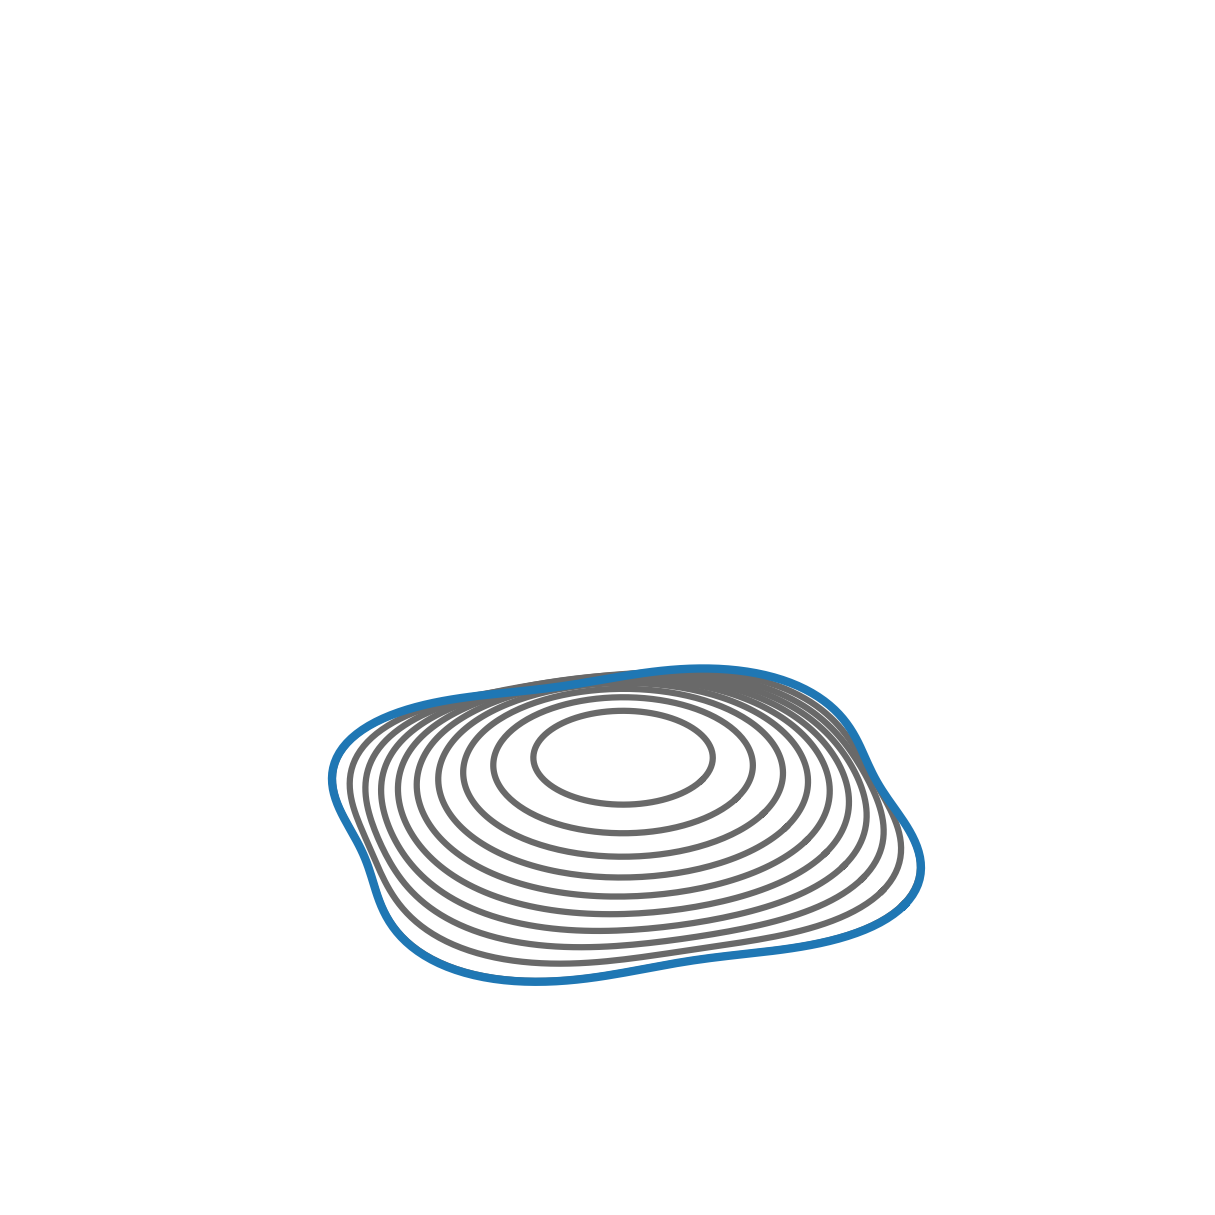

In [70]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(1,Dimensions,20):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('1.pdf', bbox_inches='tight')

## N=3

In [71]:
Radius = radius(THETA_RANGES, C_RANGES, m_matrix[1], N_cs[1])
Radius.shape
x = Radius*np.cos(THETA_RANGES)
y = Radius*np.sin(THETA_RANGES)
z = Height[1]*(C_RANGES)**n_matrix[1]
z_0 = np.ones(THETA_RANGES.shape[0])

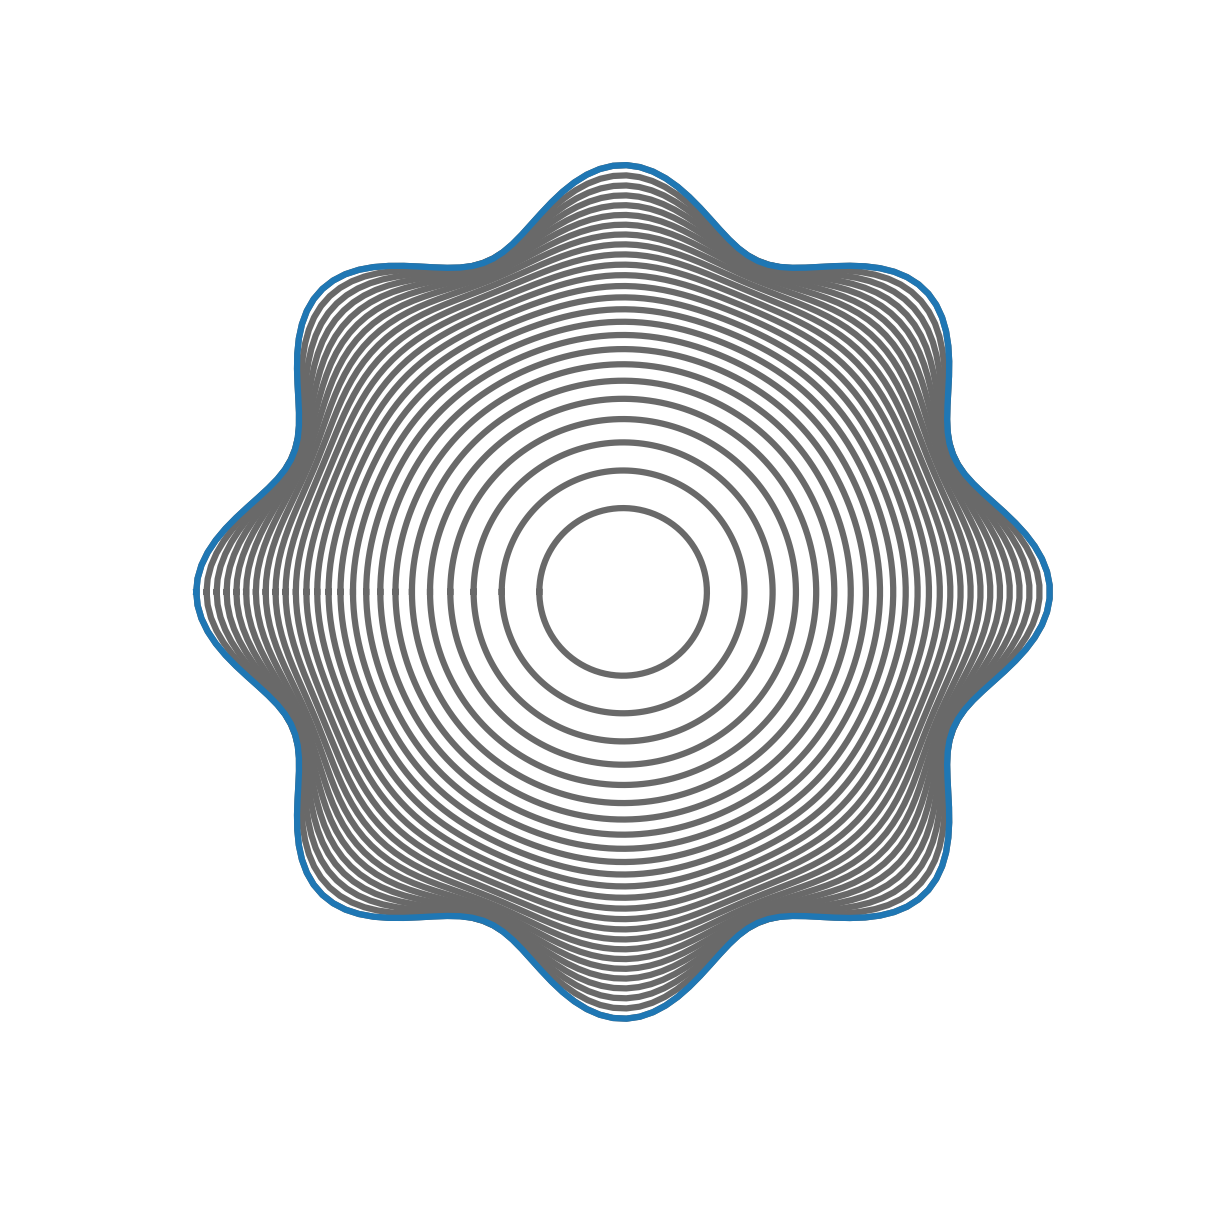

In [72]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
#ax.view_init(elev=-3, azim=0)
ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=0)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,8):
        ax.plot(x[i], y[i], z_0*z[i], color='dimgrey')
#ax.plot(x[190],y[190],z_0*z[190])
ax.plot(x[0],y[0],z_0*z[0])
ax.set_zlim(0, 1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)


ax.set_axis_off()
ax.grid(False)
fig.savefig('2_top.pdf', bbox_inches='tight')

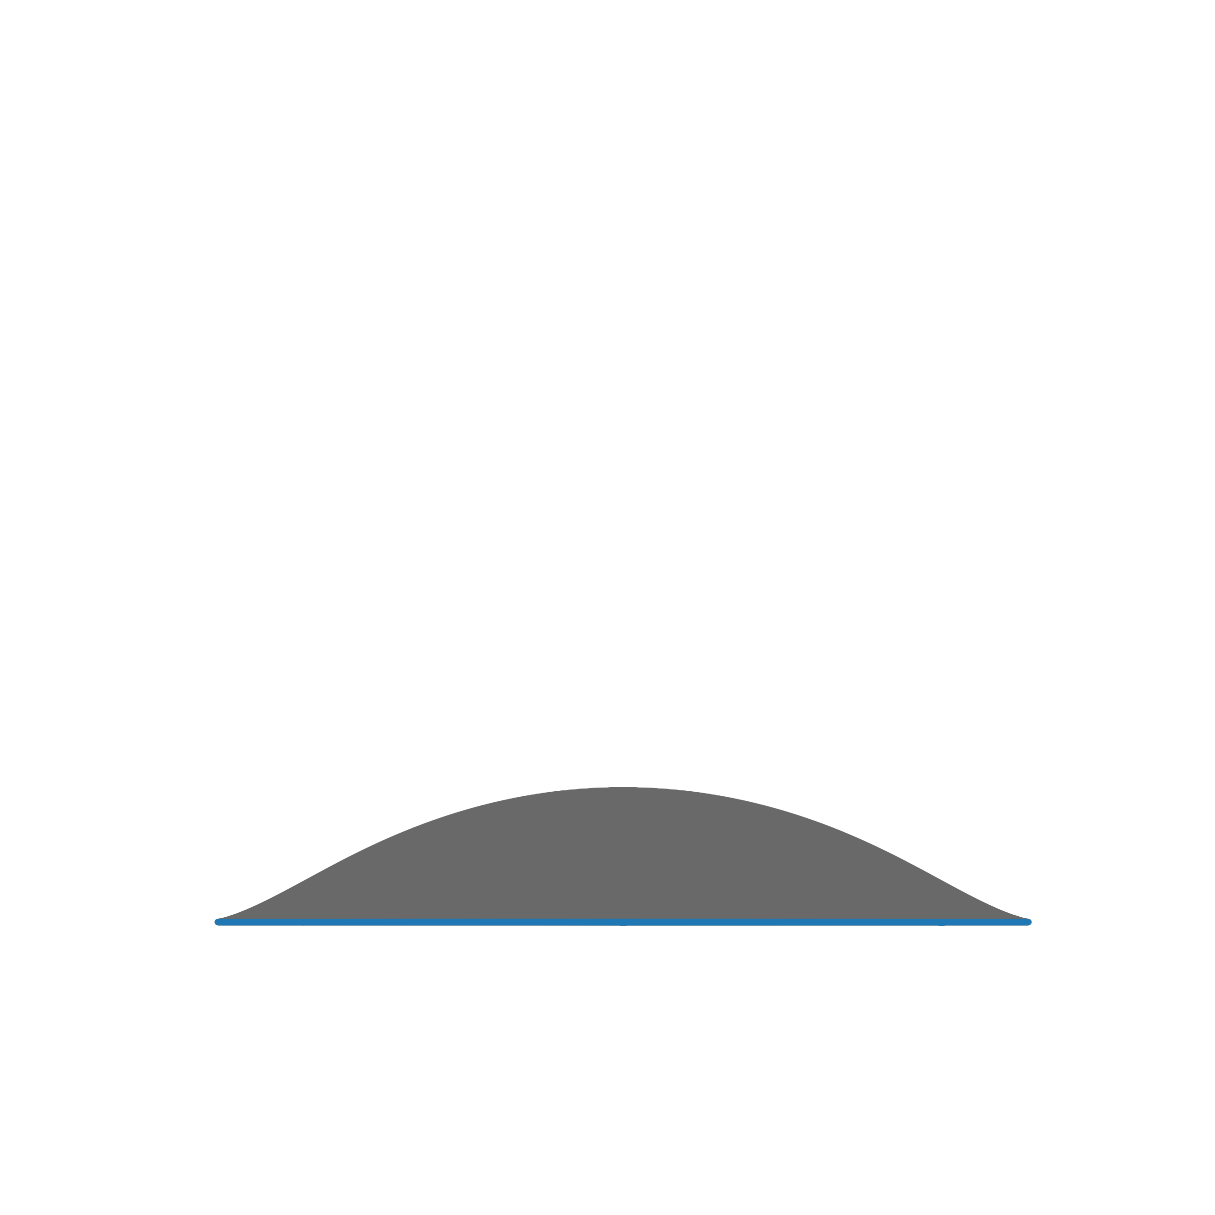

In [73]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
ax.view_init(elev=-3, azim=0)
#ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=0)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))


for i in np.arange(0,Dimensions,1):
        ax.plot(x[i], y[i], z_0*z[i], color='dimgrey')
#ax.plot(x[190],y[190],z_0*z[190])
ax.plot(x[0],y[0],z_0*z[0])
ax.set_zlim(0, 1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)

ax.set_axis_off()
ax.grid(False)
fig.savefig('2_side.pdf.pdf', bbox_inches='tight')

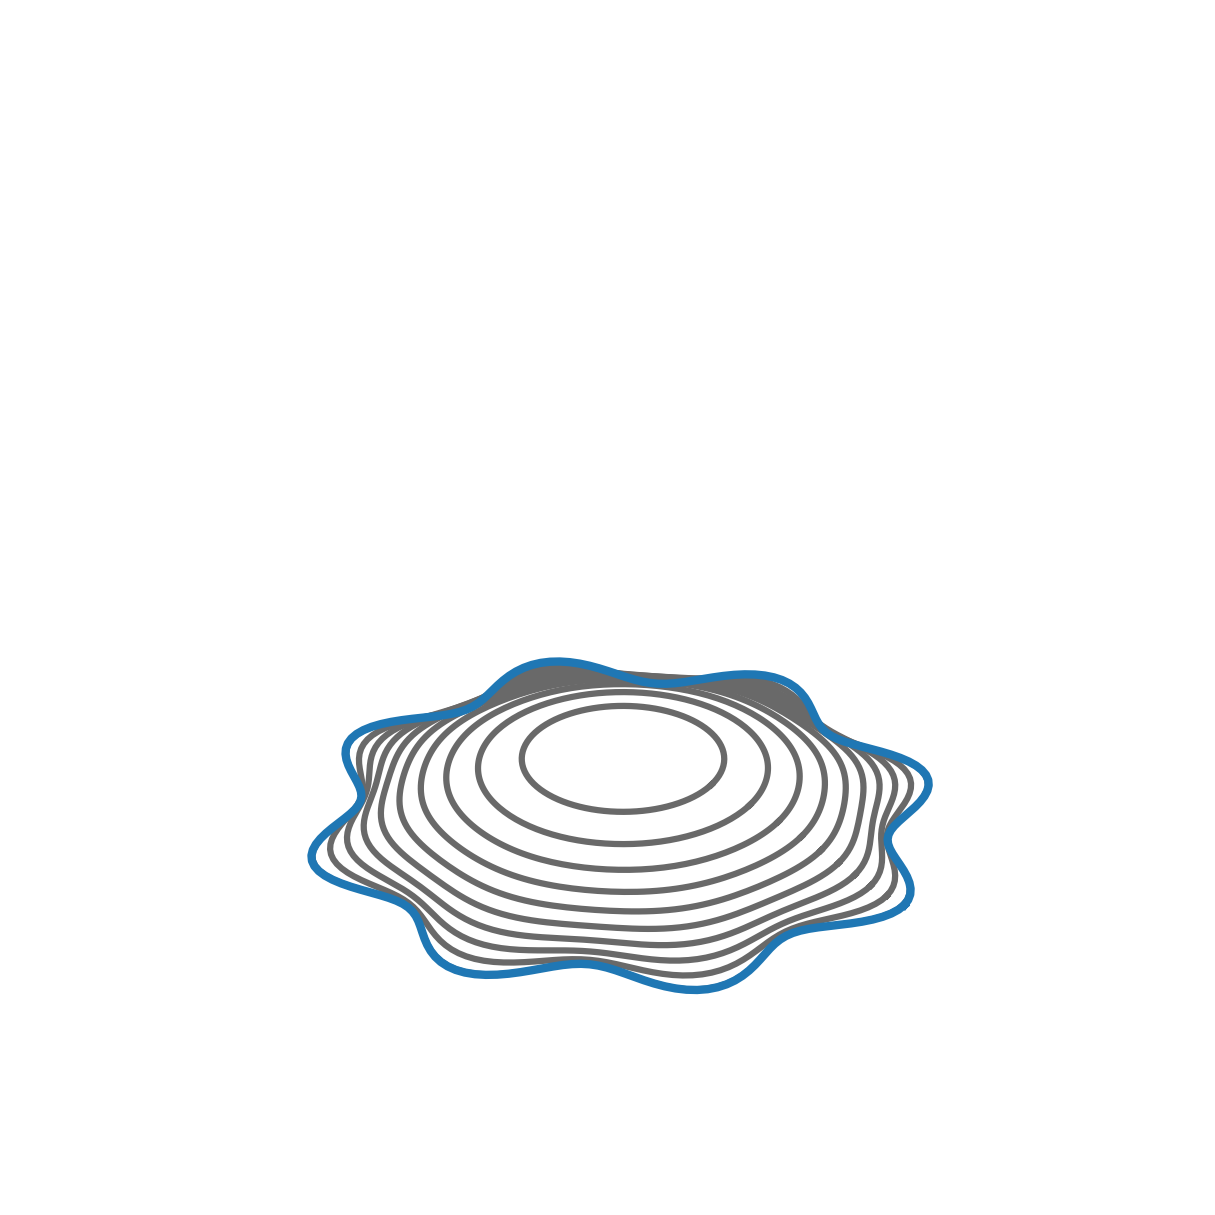

In [74]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(1,Dimensions,20):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('2.pdf', bbox_inches='tight')

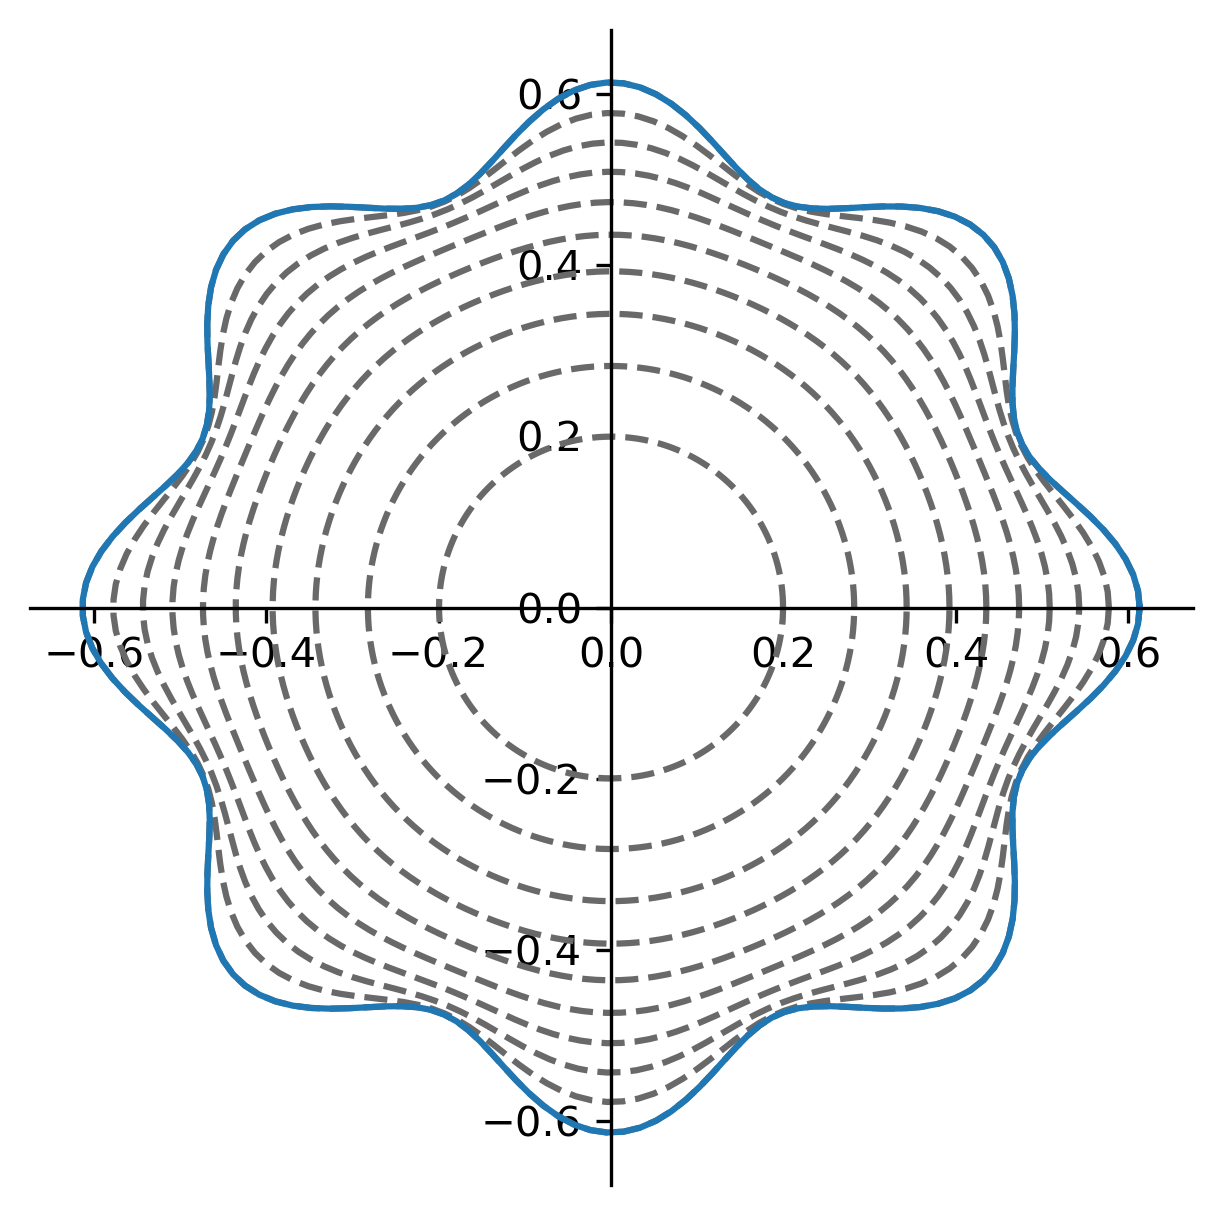

In [27]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax=fig.add_subplot(1,1,1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in np.arange(0,Dimensions,20):
    ax.plot(x[i], y[i],linestyle='--',color='dimgrey')

ax.plot(x[0], y[0])
#fig.savefig('Non-circular-N3.pdf', bbox_inches='tight')

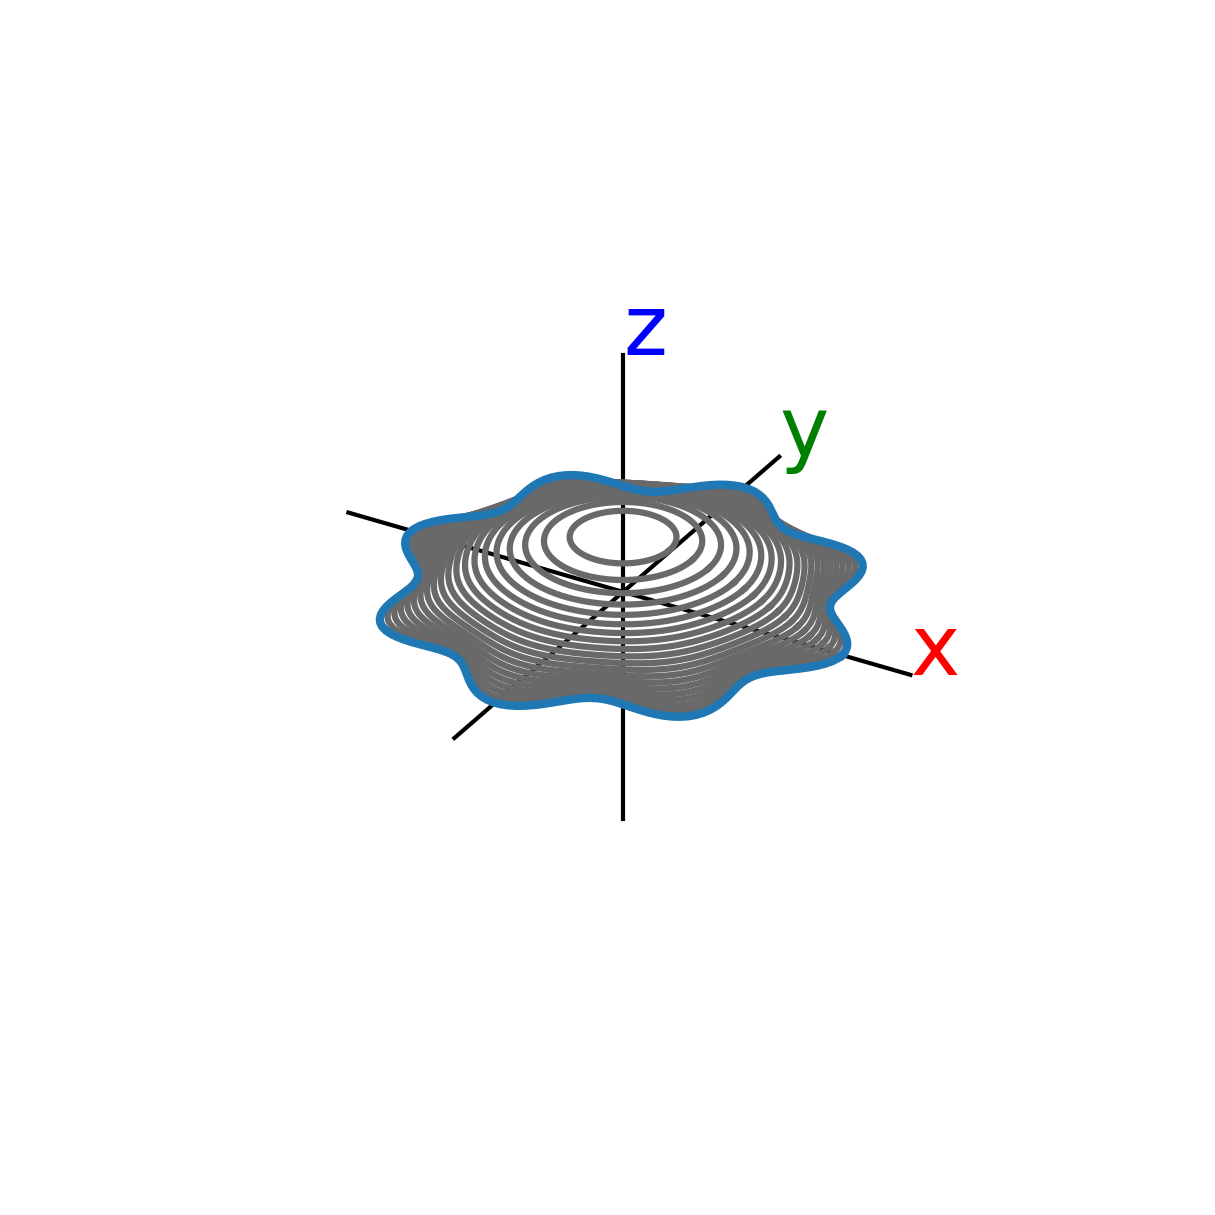

In [28]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

val = [0.8,0,0]
labels = ['x', 'y', 'z']
colors = ['r', 'g', 'b']
for v in range(3):
    axx = [val[v-0], -val[v-0]]
    axy = [val[v-1], -val[v-1]]
    axz = [val[v-2], -val[v-2]]
    ax.plot(axx,axy,axz,'k-', linewidth=1)
    ax.text(val[v-0], val[v-1], val[v-2], labels[v], color=colors[v], fontsize=20)


for i in np.arange(1,Dimensions,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
# ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-N3_with_xyz.pdf', bbox_inches='tight')

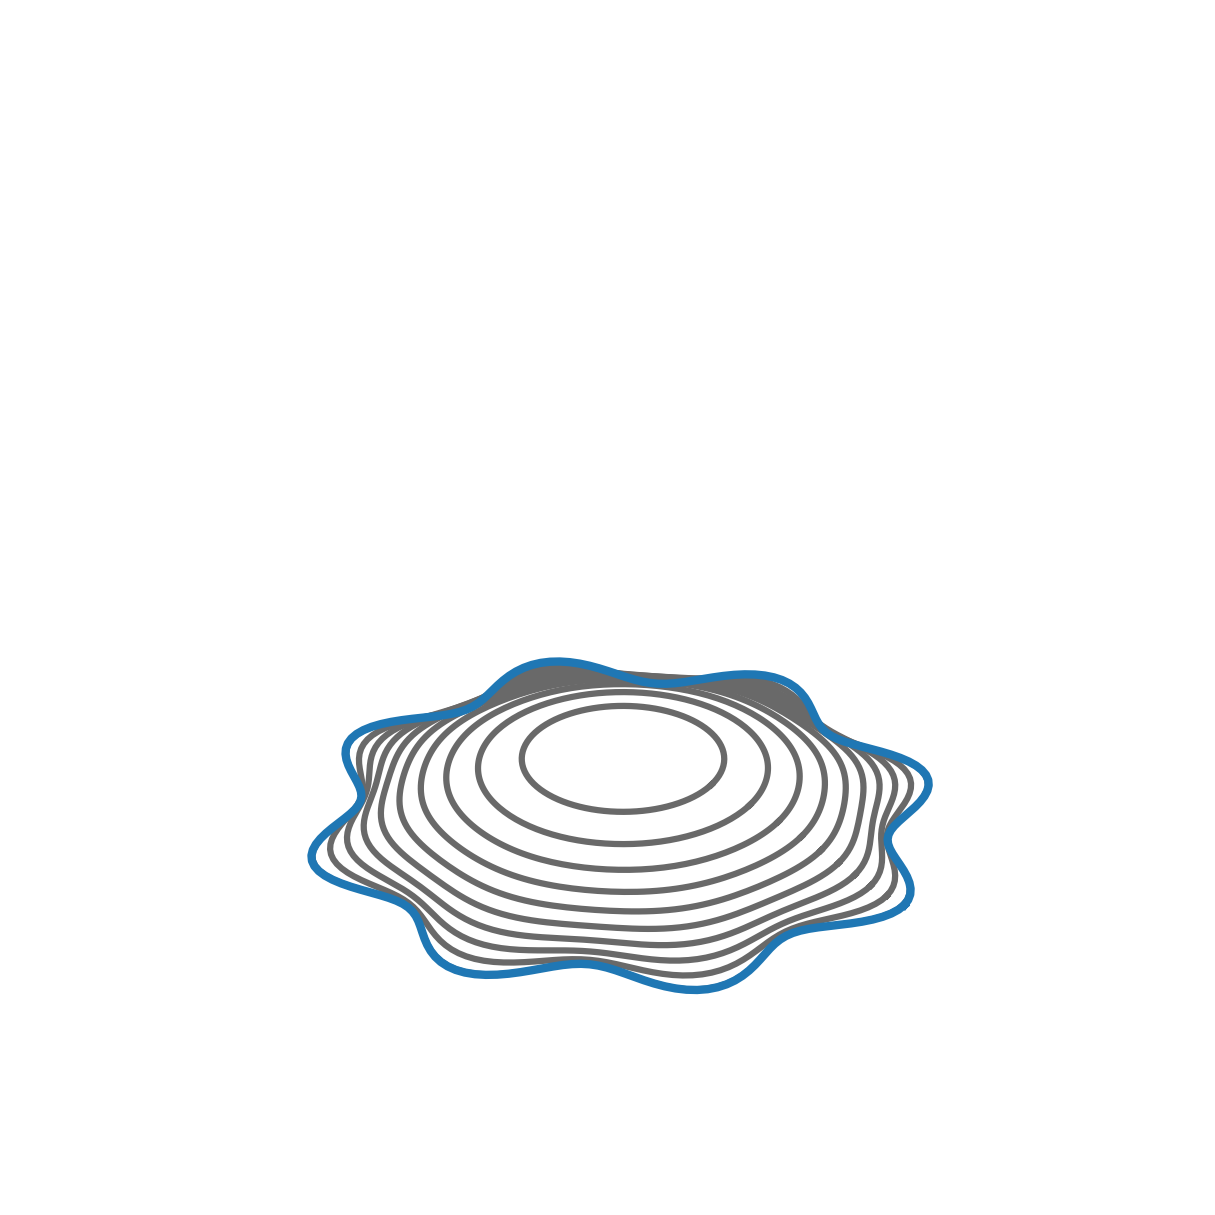

In [29]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(1,Dimensions,20):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-N3_3D.pdf', bbox_inches='tight')

## N=4

In [75]:
Radius = radius(THETA_RANGES, C_RANGES, m_matrix[2], N_cs[2])
Radius.shape
x = Radius*np.cos(THETA_RANGES)
y = Radius*np.sin(THETA_RANGES)
z = Height[2]*(C_RANGES)**n_matrix[2]
z_0 = np.ones(THETA_RANGES.shape[0])

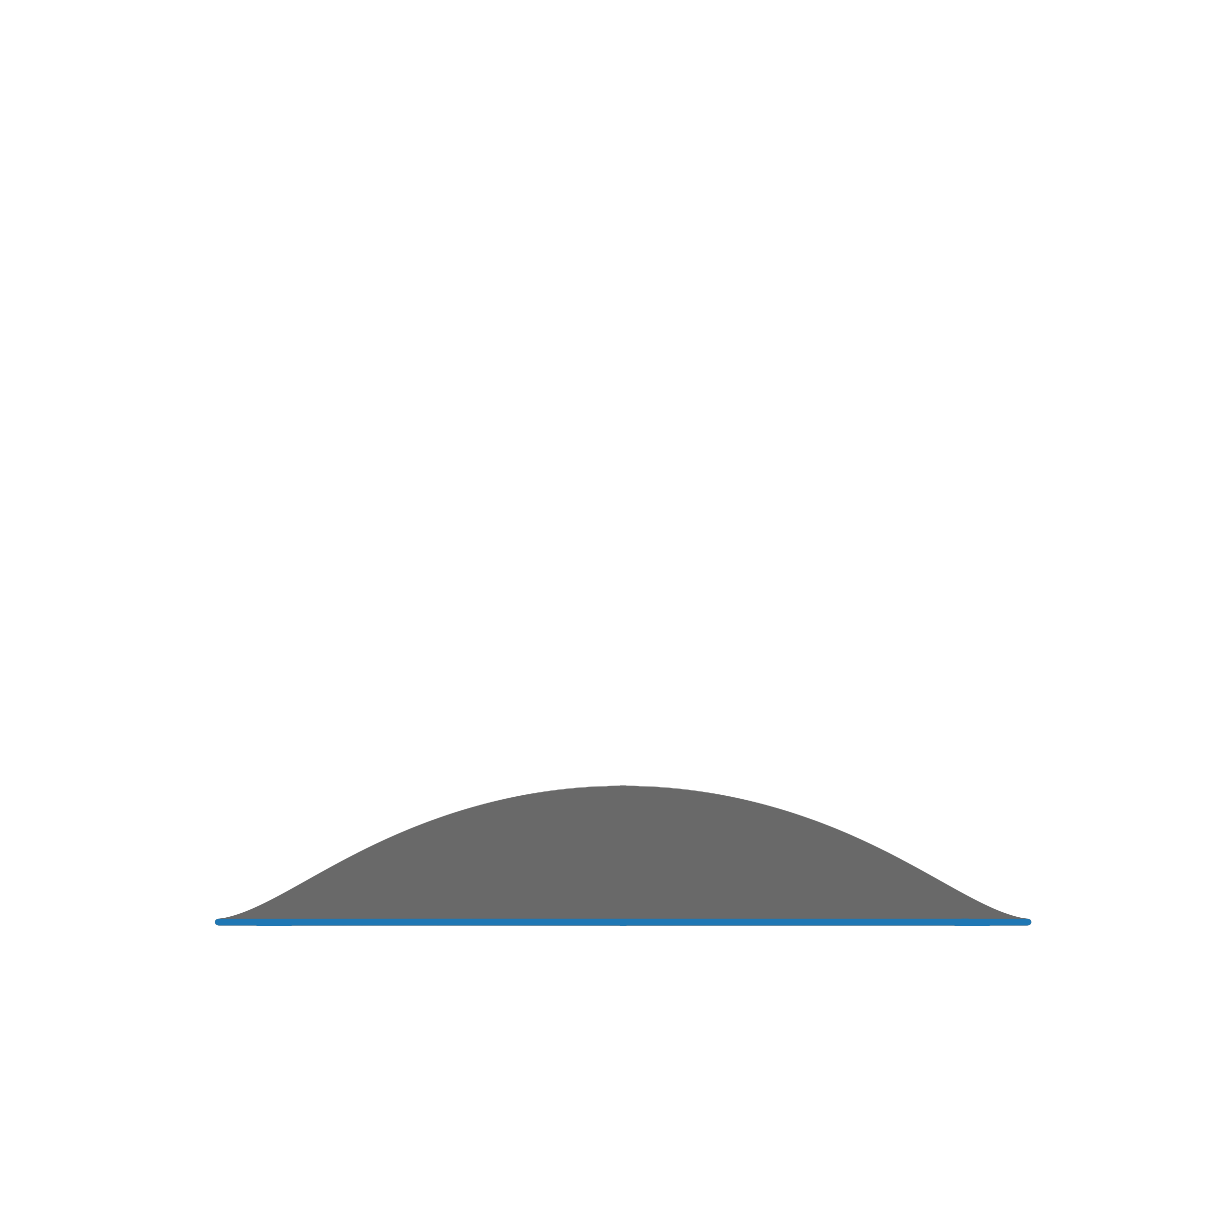

In [76]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
ax.view_init(elev=-3, azim=0)
#ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=0)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,1):
        ax.plot(x[i], y[i], z_0*z[i], color='dimgrey')
#ax.plot(x[190],y[190],z_0*z[190])
ax.plot(x[0],y[0],z_0*z[0])
ax.set_zlim(0, 1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)


ax.set_axis_off()
ax.grid(False)
fig.savefig('3_side.pdf', bbox_inches='tight')

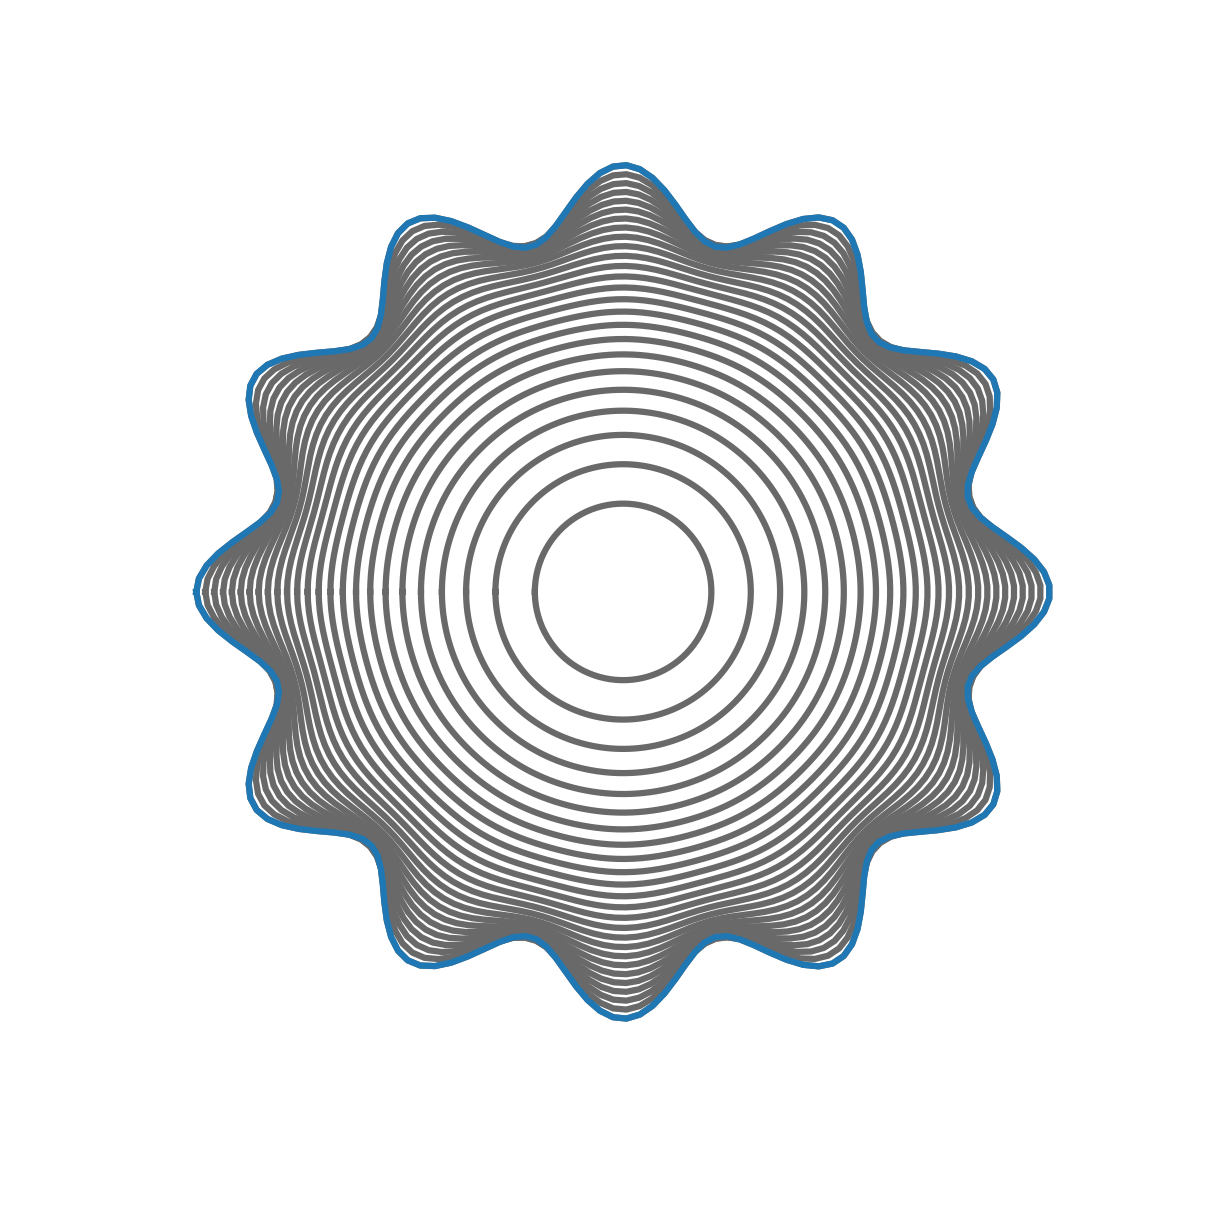

In [64]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
#ax.view_init(elev=-3, azim=0)
ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=45)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,8):
        ax.plot(x[i], y[i], z_0*z[i], color='dimgrey')
#ax.plot(x[190],y[190],z_0*z[190])
ax.plot(x[0],y[0],z_0*z[0])
ax.set_zlim(0, 1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)


ax.set_axis_off()
ax.grid(False)
fig.savefig('3_top.pdf', bbox_inches='tight')

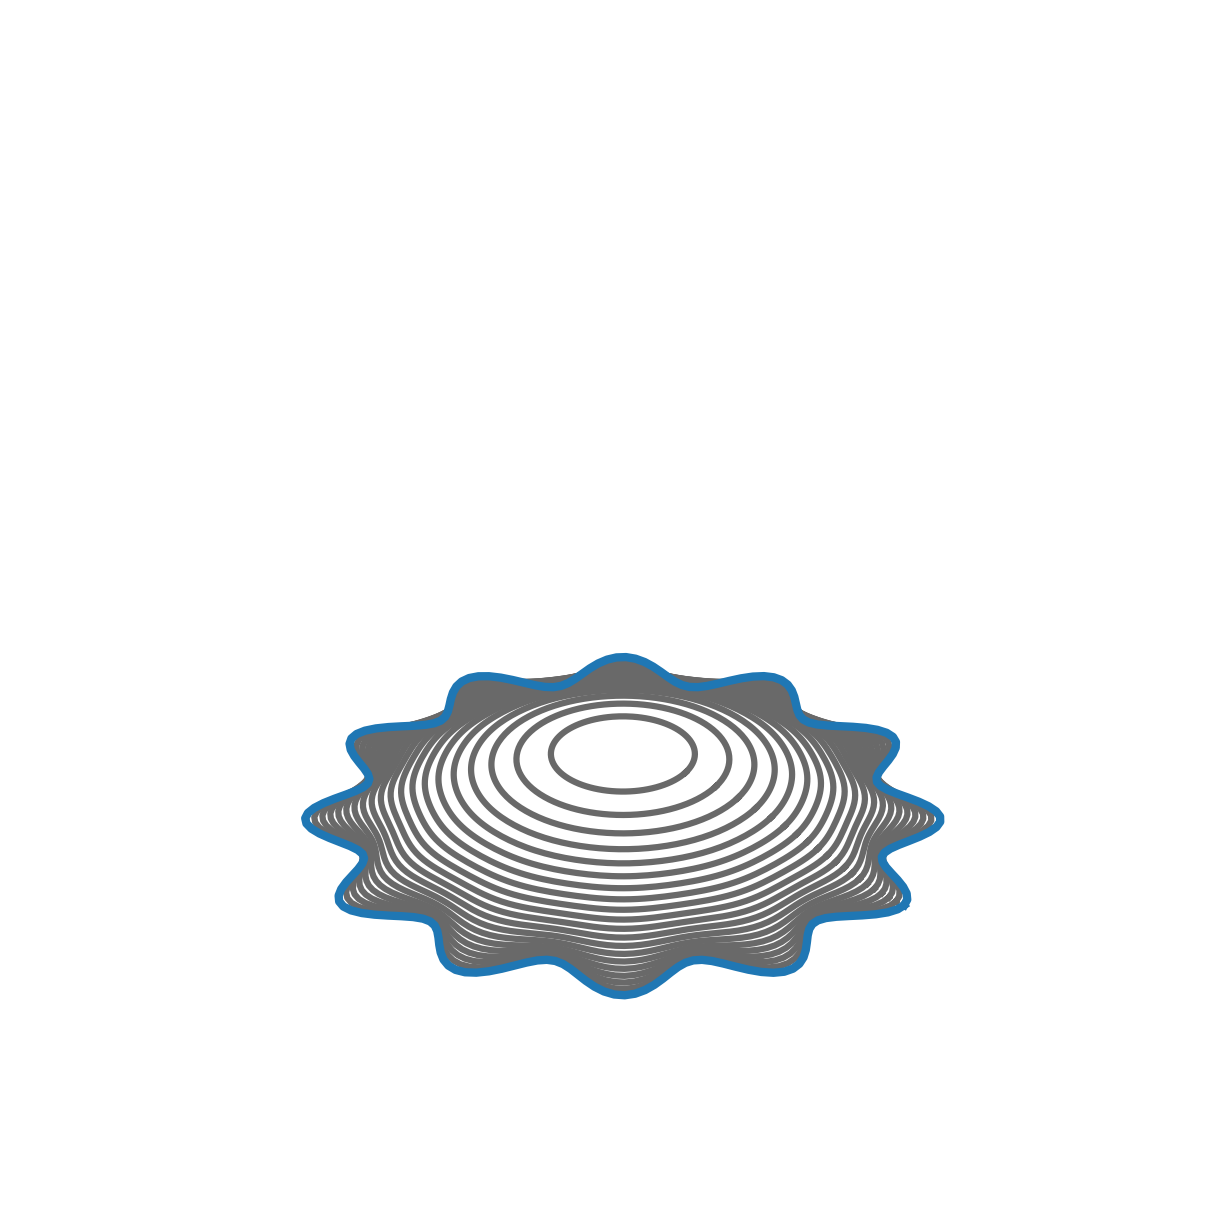

In [77]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(1,Dimensions,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('3.pdf', bbox_inches='tight')

### N=6

In [78]:
Radius = radius(THETA_RANGES, C_RANGES, m_matrix[3], N_cs[3])
Radius.shape
x = Radius*np.cos(THETA_RANGES)
y = Radius*np.sin(THETA_RANGES)
z = Height[3]*(C_RANGES)**n_matrix[3]
z_0 = np.ones(THETA_RANGES.shape[0])

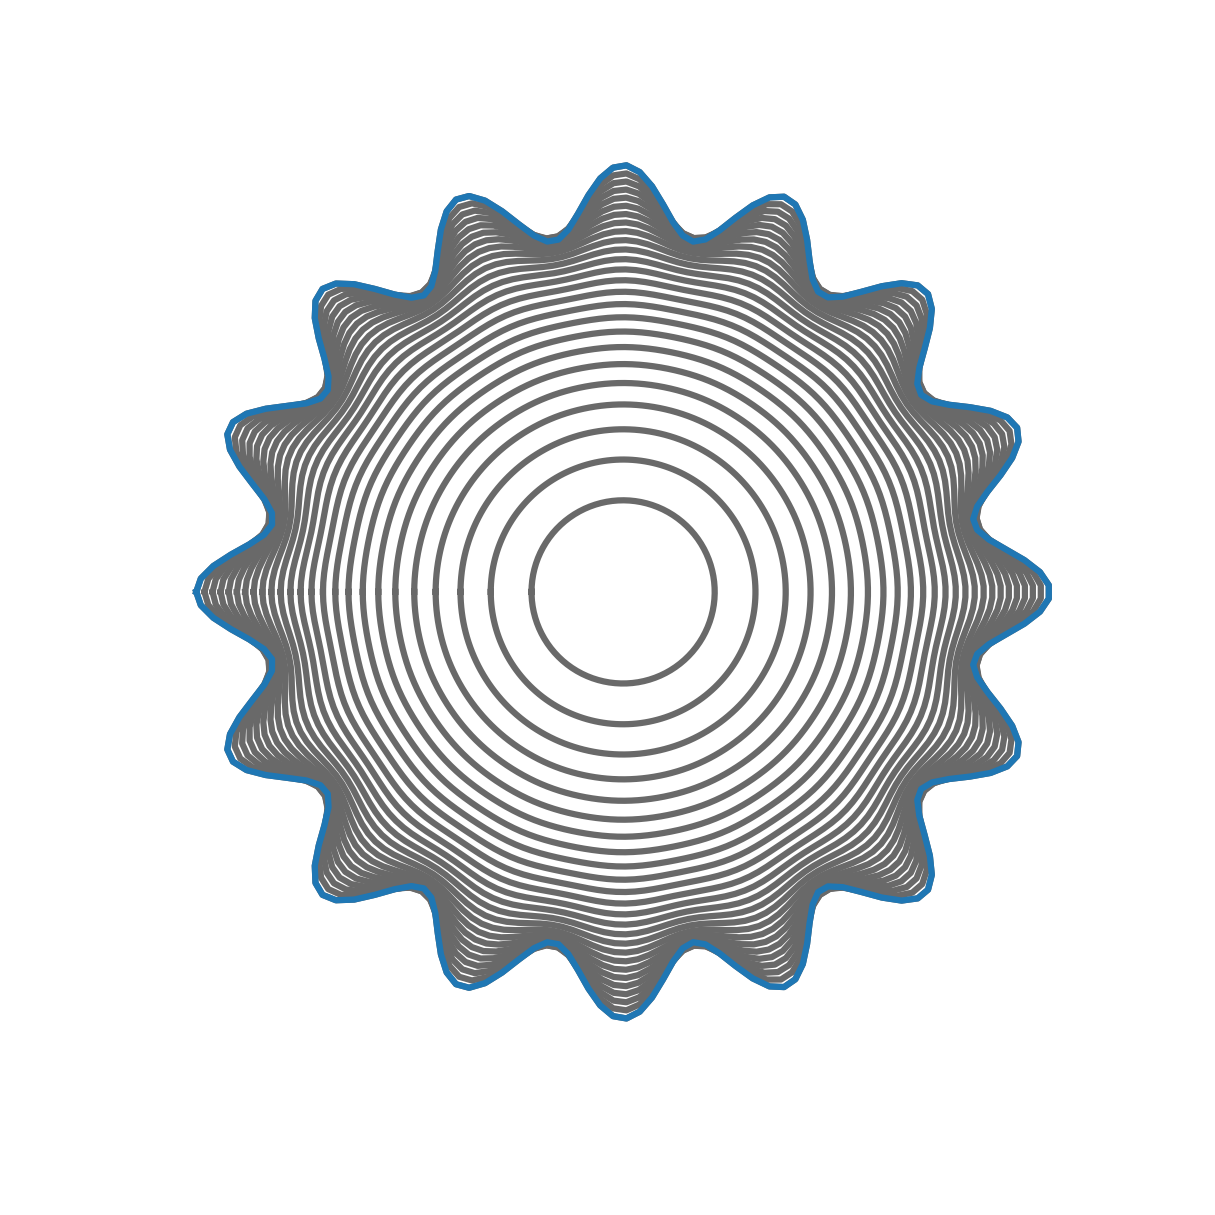

In [66]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
#ax.view_init(elev=-3, azim=0)
ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=0)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,8):
        ax.plot(x[i], y[i], z_0*z[i], color='dimgrey')
#ax.plot(x[190],y[190],z_0*z[190])
ax.plot(x[0],y[0],z_0*z[0])
ax.set_zlim(0, 1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)


ax.set_axis_off()
ax.grid(False)
fig.savefig('4_top.pdf', bbox_inches='tight')

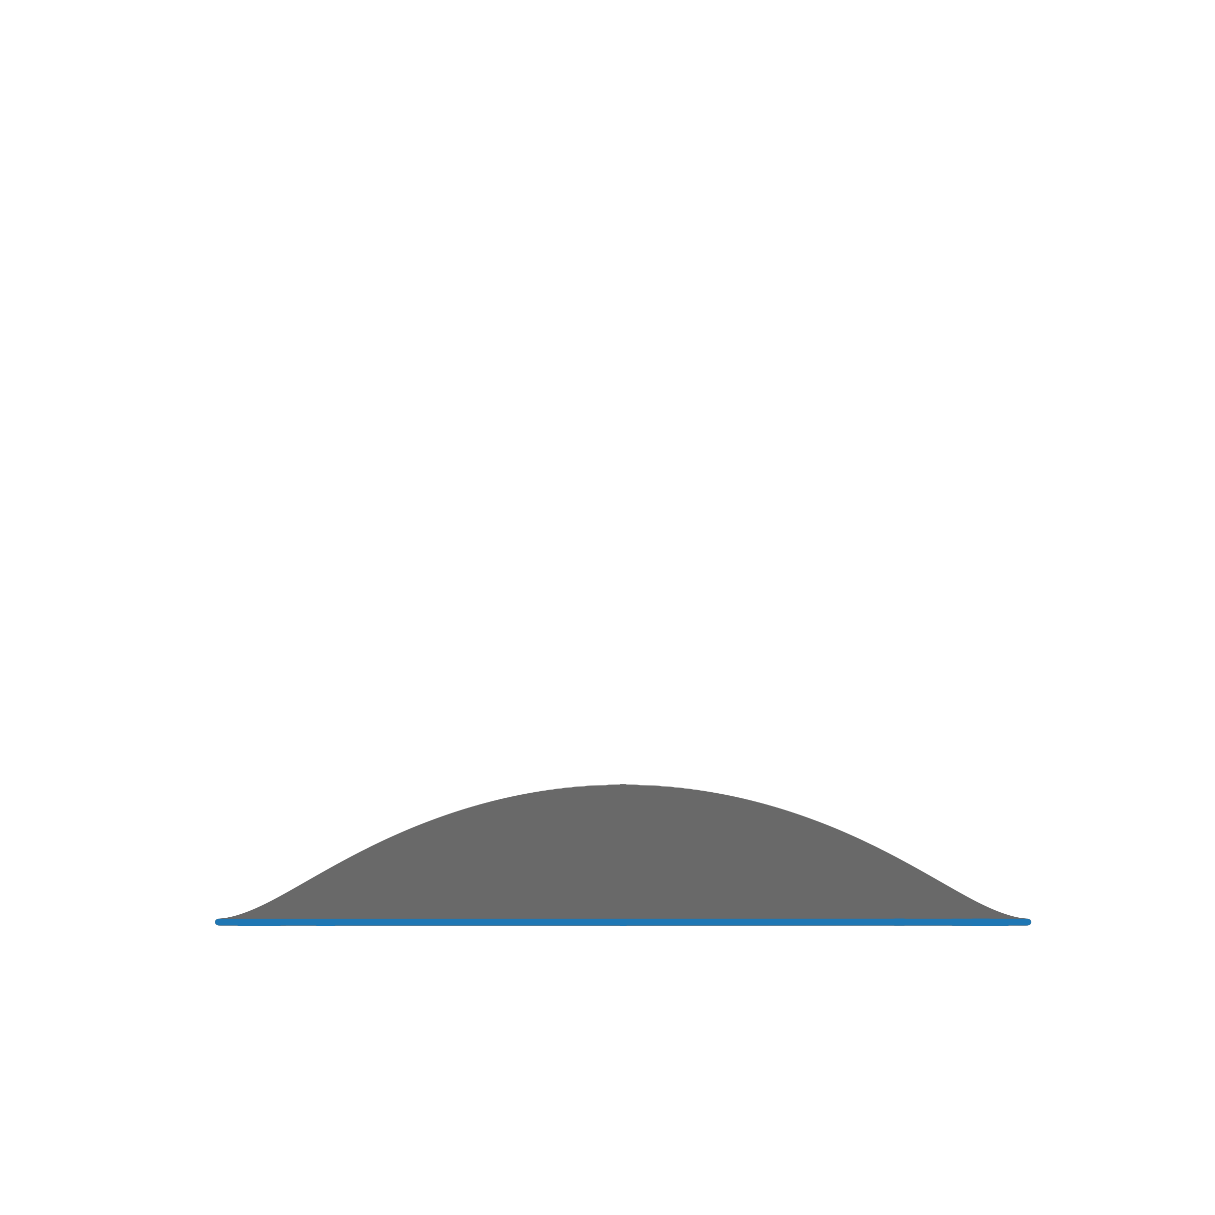

In [53]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
ax.view_init(elev=-3, azim=0)
#ax.view_init(elev=-90, azim=90)
#ax.view_init(elev=20, azim=0)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,1):
        ax.plot(x[i], y[i], z_0*z[i], color='dimgrey')
#ax.plot(x[190],y[190],z_0*z[190])
#ax.plot(x[5],y[5],z_0*z[5])
ax.set_zlim(0, 1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.plot(x[0],y[0],z_0*z[0])

ax.set_axis_off()
ax.grid(False)
fig.savefig('4_side.pdf', bbox_inches='tight')

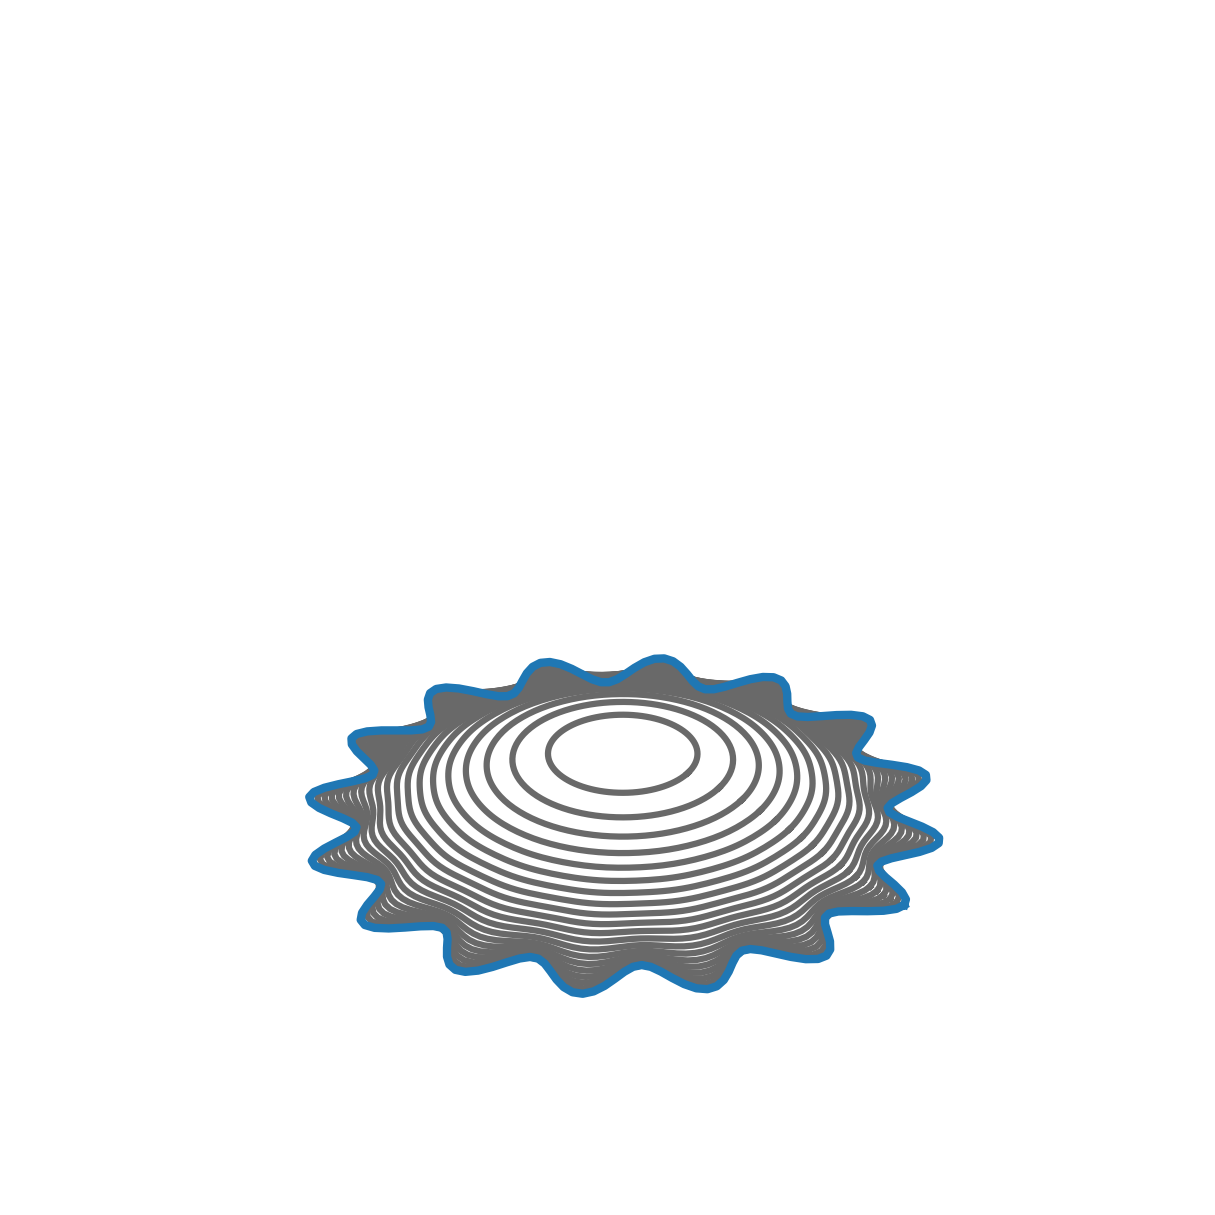

In [79]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(1,Dimensions,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('4.pdf', bbox_inches='tight')

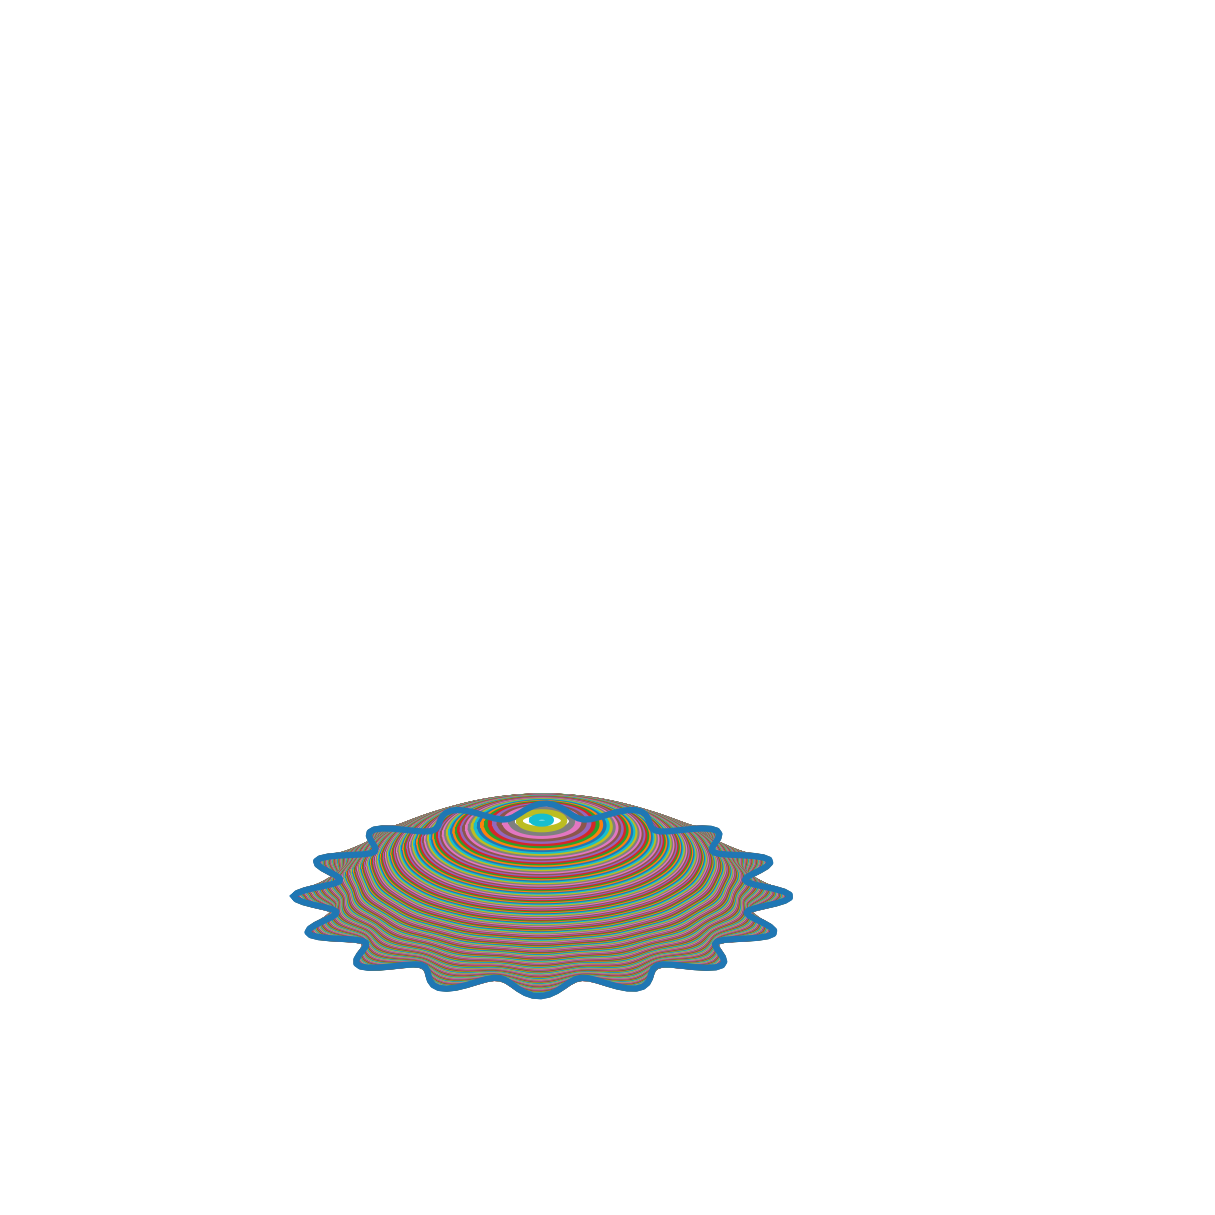

In [39]:
fig = plt.figure(figsize = (5,5), dpi=300)
#fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
#ax.view_init(elev=-90, azim=0, roll=0)
#ax.view_init(elev=-3, azim=0)
#ax.view_init(elev=-90, azim=90)
ax.view_init(elev=20, azim=90)
plt.axis("equal")
ax.set_box_aspect([1,1,1])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(0,Dimensions,1):
        ax.plot(x[i], y[i], z_0*z[i])
#ax.plot(x[190],y[190],z_0*z[190])
ax.plot(x[0],y[0],z_0*z[0])
ax.set_zlim(0, 1.6)
ax.set_xlim(-1, 0.6)
ax.set_ylim(-0.8, 0.8)


ax.set_axis_off()
ax.grid(False)
fig.savefig('contour_3Dhex01.pdf', bbox_inches='tight')

In [40]:
Radius = radius(THETA_RANGES, C_RANGES, m_matrix[4], N_cs[4])
Radius.shape
x = Radius*np.cos(THETA_RANGES)
y = Radius*np.sin(THETA_RANGES)
z = Height[4]*(C_RANGES)**n_matrix[4]
z_0 = np.ones(THETA_RANGES.shape[0])